In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import shap
from pathlib import Path

# Split, CV, GridSearch
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)

# Pipeline & preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Evaluation metrics & plots
from sklearn.metrics import (
    RocCurveDisplay,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    make_scorer
)


/Users/oleksandr/portfolio/churn-project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/processed/processed.csv')
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,False,False,False,False,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,False,False,False,False,False,True,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,False,False,False,False,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,False,False,False,False,False,False,False,False,True,False


In [3]:
X = df.drop(columns='Churn')
y = df['Churn']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1000))])

In [5]:
param_grid = {
    "model__C": [0.01, 0.1, 1, 10], 
    #"model__penalty": ["l2"],       
    "model__solver": ["liblinear"] 
}

In [6]:
cv = StratifiedKFold(shuffle=True, random_state= 42, n_splits=5)

In [7]:
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

grid.fit(X_train,y_train)

print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

best_model = grid.best_estimator_

Best params: {'model__C': 10, 'model__solver': 'liblinear'}
Best CV ROC-AUC: 0.8463615738836718


In [8]:
y_pred_lr = best_model.predict(X_test)

y_proba_lr = best_model.predict_proba(X_test)[:, 1]

y_pred_lr.shape, y_proba_lr.shape

((1409,), (1409,))

In [9]:
metrics = {
    "Precision": precision_score(y_test, y_pred_lr),
    "Recall": recall_score(y_test, y_pred_lr),
    "F1": f1_score(y_test, y_pred_lr),
    "ROC-AUC": roc_auc_score(y_test, y_proba_lr)
}

metrics

{'Precision': 0.6540880503144654,
 'Recall': 0.5561497326203209,
 'F1': 0.6011560693641619,
 'ROC-AUC': 0.841106719367589}

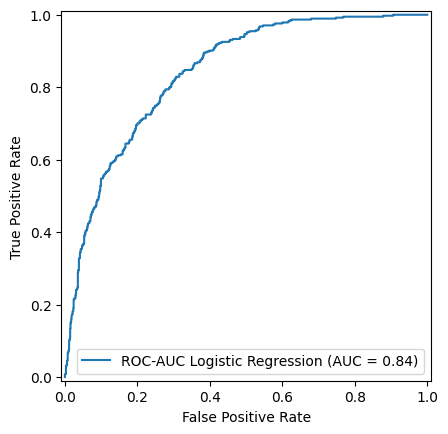

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  name='ROC-AUC Logistic Regression')
display.plot()

In [11]:
y_pred_lr_03 = (y_proba_lr >= 0.3).astype(int)

The decision threshold was set to 0.3 instead of the default 0.5 to improve churn recall and reduce the number of missed churn cases.

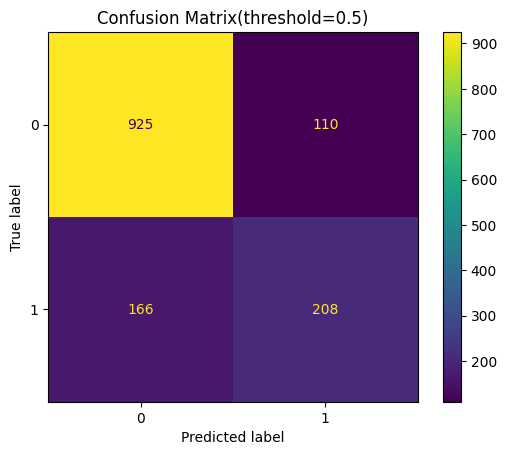

In [12]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)
plt.title('Confusion Matrix(threshold=0.5)')
plt.show()

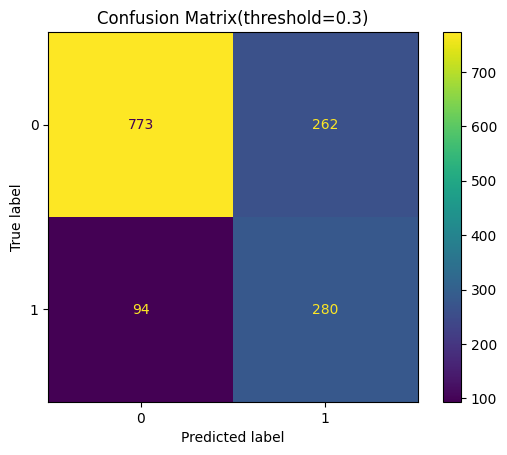

Threshold 0.3: Precision=0.517, Recall=0.749, F1=0.611


In [13]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr_03)
plt.title('Confusion Matrix(threshold=0.3)')
plt.show()

print(
    f"Threshold 0.3: "
    f"Precision={precision_score(y_test, y_pred_lr_03):.3f}, "
    f"Recall={recall_score(y_test, y_pred_lr_03):.3f}, "
    f"F1={f1_score(y_test, y_pred_lr_03):.3f}"
)

Lowering the decision threshold to 0.3 significantly reduced the number of false negatives and increased churn recall to approximately 75%. Although this resulted in more false positives, the trade-off is acceptable given the higher cost of missed churn cases.

The model demonstrates strong ranking performance (ROC-AUC = 0.84). By lowering the decision threshold to 0.3, recall increased to ~75%, reducing the number of missed churn cases at the cost of lower precision.

# Random Forest

Random Forest is an ensemble method that combines multiple decision trees trained on random subsets of data and features, allowing the model to capture non-linear relationships and feature interactions.

In [14]:
pipeline = Pipeline(steps=[('random_forest', RandomForestClassifier())])
param_grid = {
    'random_forest__max_depth': [1, 2, 3, 4, 5],
    'random_forest__n_estimators': [100, 200, 300]
}
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

grid.fit(X_train,y_train)

print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

best_model_rf = grid.best_estimator_

Best params: {'random_forest__max_depth': 5, 'random_forest__n_estimators': 100}
Best CV ROC-AUC: 0.8450844238909718


In [15]:
y_pred_rf = best_model_rf.predict(X_test)

y_proba_rf = best_model_rf.predict_proba(X_test)[:,1]

y_pred_rf.shape, y_proba_rf.shape

((1409,), (1409,))

In [16]:
#Threshold 0.5
metrics = {
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "ROC-AUC": roc_auc_score(y_test, y_proba_rf)
}

metrics

{'Precision': 0.6652173913043479,
 'Recall': 0.4090909090909091,
 'F1': 0.5066225165562914,
 'ROC-AUC': 0.839533441835232}

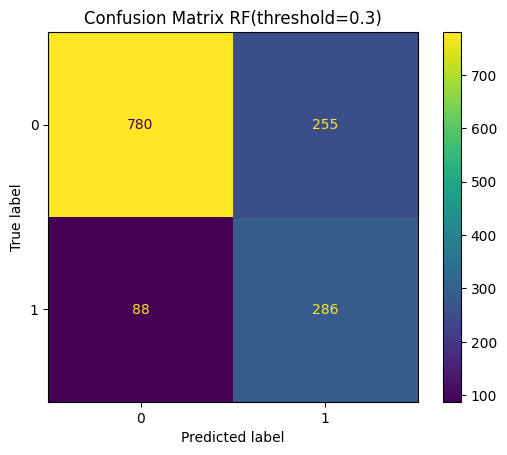

Threshold 0.3: Precision=0.529, Recall=0.765, F1=0.625


In [17]:
y_pred_rf_03 = (y_proba_rf >= 0.3).astype(int)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_03)
plt.title('Confusion Matrix RF(threshold=0.3)')
plt.show()

print(
    f"Threshold 0.3: "
    f"Precision={precision_score(y_test, y_pred_rf_03):.3f}, "
    f"Recall={recall_score(y_test, y_pred_rf_03):.3f}, "
    f"F1={f1_score(y_test, y_pred_rf_03):.3f}"
)

After tuning the decision threshold to 0.3, Random Forest slightly outperformed Logistic Regression across all key metrics, achieving higher recall and precision while maintaining a similar ROC-AUC. This suggests that non-linear feature interactions provide additional predictive power for churn detection.

Model Explainability (SHAP)

To better understand model decisions, SHAP (SHapley Additive exPlanations) was used 
to analyze feature impact on churn predictions.

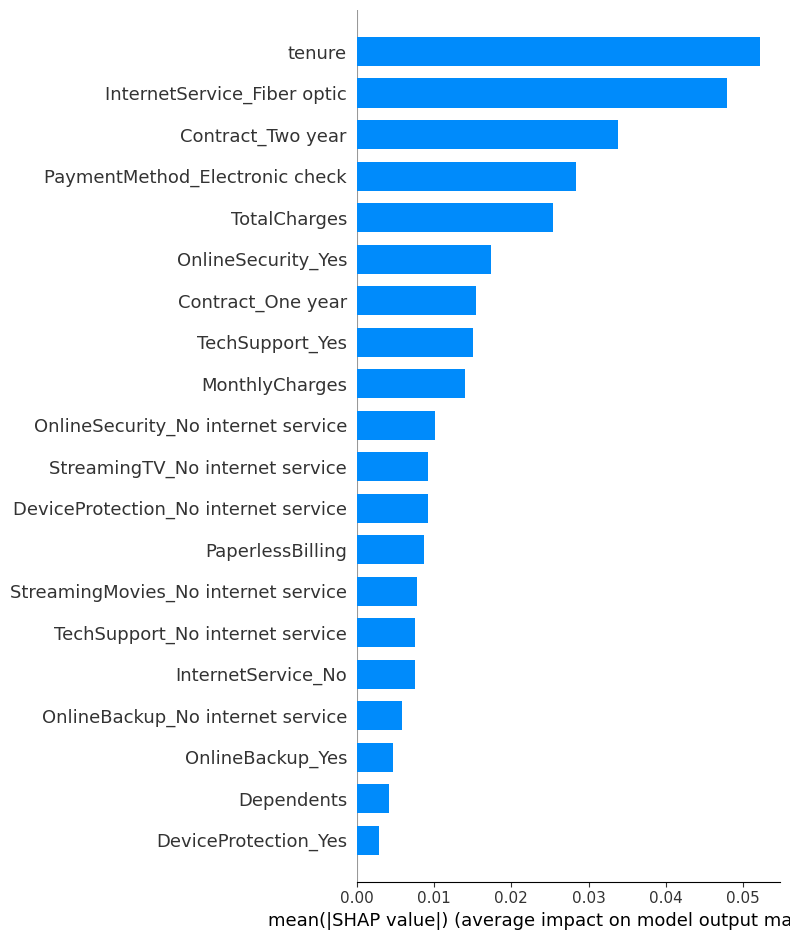

In [35]:
rf_model = best_model_rf.named_steps['random_forest']
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[:,:,1], X_train, plot_type='bar')


Key findings:

- Short customer tenure significantly increases churn probability.
- Long-term contracts (Two-year) strongly reduce churn risk.
- Fiber optic internet service is associated with higher churn probability.
- Payment method and total charges also contribute to churn behavior.

SHAP analysis confirms that contract duration and customer lifetime are the most important drivers of churn.

# Gradient Boosting

Gradient Boosting was evaluated as a more expressive ensemble model. After threshold tuning, its performance was compared against Random Forest and Logistic Regression under the same recall-oriented decision rule.

In [19]:
pipeline = Pipeline(steps=[('gb',GradientBoostingClassifier())])

param_grid = {
    'gb__n_estimators': [100, 200, 300],
    'gb__max_depth': [2, 3, 4, 5],
    'gb__learning_rate': [0.05, 0.1, 0.2]
}

grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

best_model_gb = grid.best_estimator_


Best params: {'gb__learning_rate': 0.05, 'gb__max_depth': 2, 'gb__n_estimators': 200}
Best CV ROC-AUC: 0.8494376152657732


In [20]:
y_pred_gb = best_model.predict(X_test)

y_proba_gb = best_model.predict_proba(X_test)[:, 1]

y_pred_gb.shape, y_proba_gb.shape

((1409,), (1409,))

In [21]:
# Threshold 0.5
metrics = {
    "Precision": precision_score(y_test, y_pred_gb),
    "Recall": recall_score(y_test, y_pred_gb),
    "F1": f1_score(y_test, y_pred_gb),
    "ROC-AUC": roc_auc_score(y_test, y_proba_gb)
}

metrics

{'Precision': 0.6540880503144654,
 'Recall': 0.5561497326203209,
 'F1': 0.6011560693641619,
 'ROC-AUC': 0.841106719367589}

Gradient Boosting achieved the highest cross-validated ROC-AUC, outperforming both Logistic Regression and Random Forest. The selected hyperparameters indicate a preference for shallow trees and a low learning rate, resulting in a stable and well-generalized model.

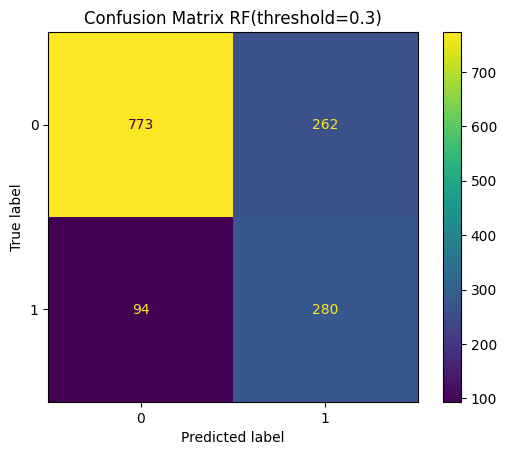

Threshold 0.3: Precision=0.517, Recall=0.749, F1=0.611


In [22]:
y_pred_gb_03 = (y_proba_gb >= 0.3).astype(int)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb_03)
plt.title('Confusion Matrix RF(threshold=0.3)')
plt.show()

print(
    f"Threshold 0.3: "
    f"Precision={precision_score(y_test, y_pred_gb_03):.3f}, "
    f"Recall={recall_score(y_test, y_pred_gb_03):.3f}, "
    f"F1={f1_score(y_test, y_pred_gb_03):.3f}"
)

Using a recall-oriented threshold of 0.3, Random Forest achieves a recall of approximately 75% with acceptable precision, making it suitable for churn detection where missing churned customers is costly.

## Neural networks Keras Dense model

In [23]:
def build_mlp(input_dim, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))  # binary classification
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["AUC"]
    )
    
    return model

In [24]:
mlp_clf = KerasClassifier(
    model=build_mlp,
    input_dim=X_train.shape[1],
    epochs=50,
    batch_size=32,
    verbose=0
)


In [25]:
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ("mlp", mlp_clf)])
param_grid = {
    "mlp__model__learning_rate": [0.001, 0.01],
    "mlp__epochs": [30, 50],
    "mlp__batch_size": [32, 64]
}

In [26]:
roc_auc_predict = make_scorer(roc_auc_score, response_method="predict")

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=roc_auc_predict,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END mlp__batch_size=32, mlp__epochs=30, mlp__model__learning_rate=0.001; total time=   9.4s
[CV] END mlp__batch_size=32, mlp__epochs=30, mlp__model__learning_rate=0.01; total time=   9.7s
[CV] END mlp__batch_size=32, mlp__epochs=30, mlp__model__learning_rate=0.01; total time=   9.8s
[CV] END mlp__batch_size=32, mlp__epochs=30, mlp__model__learning_rate=0.001; total time=   9.8s
[CV] END mlp__batch_size=32, mlp__epochs=30, mlp__model__learning_rate=0.001; total time=   9.8s
[CV] END mlp__batch_size=32, mlp__epochs=30, mlp__model__learning_rate=0.001; total time=   9.6s
[CV] END mlp__batch_size=32, mlp__epochs=30, mlp__model__learning_rate=0.01; total time=   9.9s
[CV] END mlp__batch_size=32, mlp__epochs=30, mlp__model__learning_rate=0.001; total time=   9.9s
[CV] END mlp__batch_size=32, mlp__epochs=30, mlp__model__learning_rate=0.01; total time=   9.4s
[CV] END mlp__batch_size=32, mlp__epochs=30, mlp__model__learning_rate=

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step... verbose=0))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'mlp__batch_size': [32, 64], 'mlp__epochs': [30, 50], 'mlp__model__learning_rate': [0.001, 0.01]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",make_scorer(r...hod='predict')
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation ti

In [27]:
print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

best_model_mlp = grid.best_estimator_

Best params: {'mlp__batch_size': 64, 'mlp__epochs': 30, 'mlp__model__learning_rate': 0.001}
Best CV ROC-AUC: 0.718059998463237


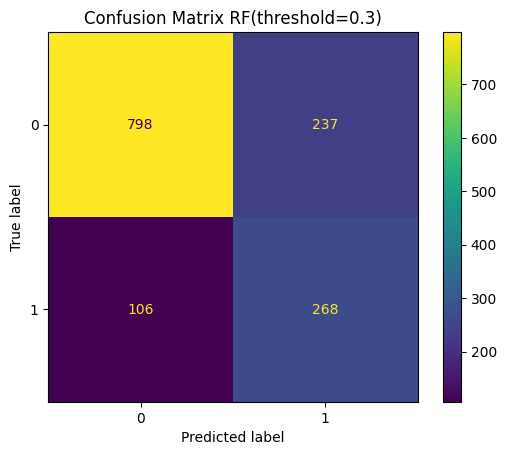

Threshold 0.3: Precision=0.531, Recall=0.717, F1=0.610


In [28]:
y_proba_mlp = best_model_mlp.predict_proba(X_test)[:, 1]
y_pred_mlp_03 = (y_proba_mlp >= 0.3).astype(int)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp_03)
plt.title('Confusion Matrix RF(threshold=0.3)')
plt.show()

print(
    f"Threshold 0.3: "
    f"Precision={precision_score(y_test, y_pred_mlp_03):.3f}, "
    f"Recall={recall_score(y_test, y_pred_mlp_03):.3f}, "
    f"F1={f1_score(y_test, y_pred_mlp_03):.3f}"
)

At a recall-oriented threshold of 0.3, the neural network model achieved the highest recall and F1-score among all evaluated models. While precision remains comparable to tree-based models, the MLP demonstrates improved ability to identify churned customers, making it a strong candidate when minimizing missed churn cases is a priority.

In [29]:
def compute_metrics(y_true, y_pred, y_proba):
    return {
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_proba)
    }

results = {
    "Logistic Regression": compute_metrics(y_test, y_pred_lr_03, y_proba_lr),
    "Random Forest": compute_metrics(y_test, y_pred_rf_03, y_proba_rf),
    "Gradient Boosting": compute_metrics(y_test, y_pred_gb_03, y_proba_gb),
    "MLP (Neural Network)": compute_metrics(y_test, y_pred_mlp_03, y_proba_mlp)
}

metrics_df = pd.DataFrame(results).T
metrics_df

,Precision,Recall,F1,ROC-AUC
Logistic Regression,0.516605,0.748663,0.611354,0.841107
Random Forest,0.528651,0.764706,0.625137,0.839533
Gradient Boosting,0.516605,0.748663,0.611354,0.841107
MLP (Neural Network),0.530693,0.716578,0.609784,0.826924


In [30]:
import joblib
from pathlib import Path

bundle = {
    "model": best_model_rf,
    "feature_names": X.columns.tolist(),
    "feature_dtypes": X.dtypes.astype(str).to_dict(),
    "threshold": 0.3
}

models_dir = Path("../models")
models_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(bundle, models_dir / "churn_rf_bundle.pkl")


['../models/churn_rf_bundle.pkl']

The final Random Forest model was saved as a serialized sklearn pipeline using joblib.
This allows seamless loading and inference in a Streamlit application without additional preprocessing steps.

The table above summarizes model performance under a unified recall-oriented threshold (0.3). While ROC-AUC reflects overall ranking quality, Precision, Recall, and F1-score are reported at the selected operating point to support business-driven model selection.

Although an MLP model was implemented to explore neural network performance, tree-based models (Random Forest and Gradient Boosting) achieved superior results on this tabular churn dataset.

Random Forest demonstrated the best balance between recall and F1-score, making it the preferred model for deployment.

This result confirms that for structured tabular data, ensemble methods often outperform neural networks without extensive feature engineering.

Final Conclusion

In this project, multiple machine learning models were evaluated for customer churn prediction, including Logistic Regression, Random Forest, Gradient Boosting, and a Multilayer Perceptron (MLP).

Logistic Regression was used as a transparent baseline model and demonstrated strong overall performance, particularly in terms of ROC-AUC. Tree-based ensemble models, especially Random Forest and Gradient Boosting, further improved predictive performance by capturing non-linear relationships in the data.

Among all evaluated models, Random Forest achieved the best balance between recall and F1-score, which is particularly important in churn prediction tasks where identifying as many churned customers as possible is a key business objective. By adjusting the decision threshold to 0.3, the model significantly increased recall while maintaining an acceptable precision level.

The MLP model was implemented to explore neural network performance on structured tabular data. However, it did not outperform ensemble methods, confirming that classical tree-based models often remain more effective for tabular datasets without extensive feature engineering.

Based on the quantitative evaluation and business considerations, Random Forest was selected as the final model for deployment. It provides strong predictive performance, robustness, and better interpretability compared to more complex neural network approaches, making it well-suited for practical churn prediction and interactive visualization in a Streamlit application.